In [1]:


from utils.libs.plotting import display_chromagram, plot_chord_heatmap
from utils.libs.chords_score import clean_chord_score_from_chroma
from utils.libs.constants import AUDIO_FILE, AUDIO_FILE_1, WINDOW_SIZE, HOP_SIZE, RATE


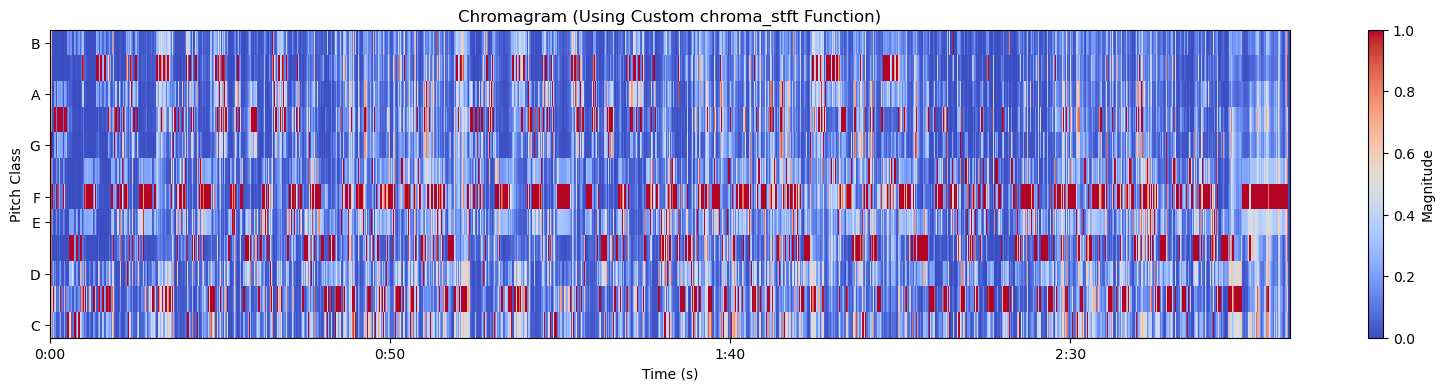

In [2]:
from utils.libs.chroma_creation import create_chroma_studio


# Compute Chroma using your function
chromaStudio = create_chroma_studio(
    file_path=AUDIO_FILE,
    fft_size=WINDOW_SIZE,
    hop_length=HOP_SIZE,
    sr=RATE
)

display_chromagram(chromaStudio.get_chroma())


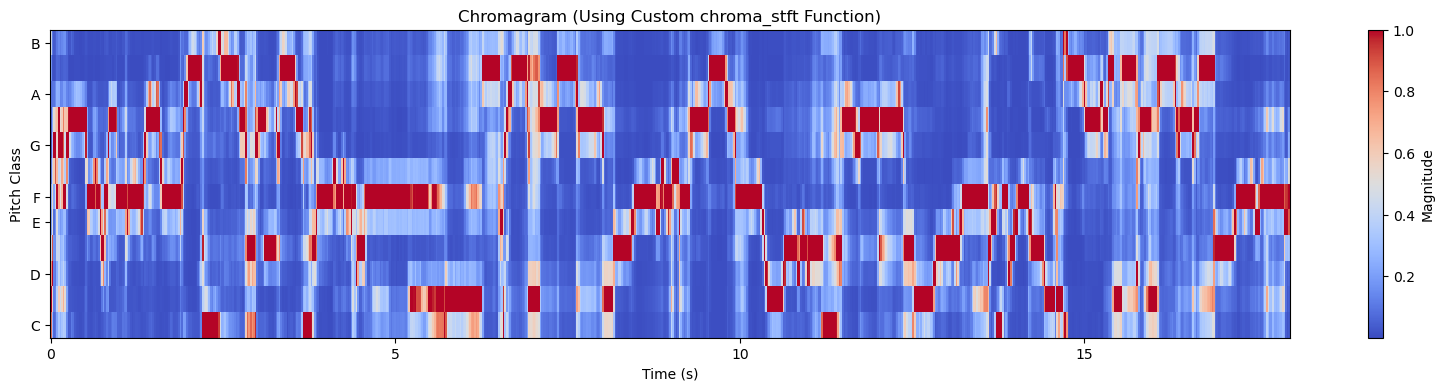

In [3]:
cut_chroma = chromaStudio.cut_time(chromaStudio.get_chroma() , 9, 18)
display_chromagram(cut_chroma)

In [4]:
def get_top_n(scores, n=6):
    return dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n])

# To sum up

In [5]:
def clean_chord_score_from_filename(file_path):
    chroma_studio = create_chroma_studio(
        file_path=file_path,
        fft_size=WINDOW_SIZE,
        hop_length=HOP_SIZE,
        sr=RATE
    )
    return clean_chord_score_from_chroma(chroma_studio)

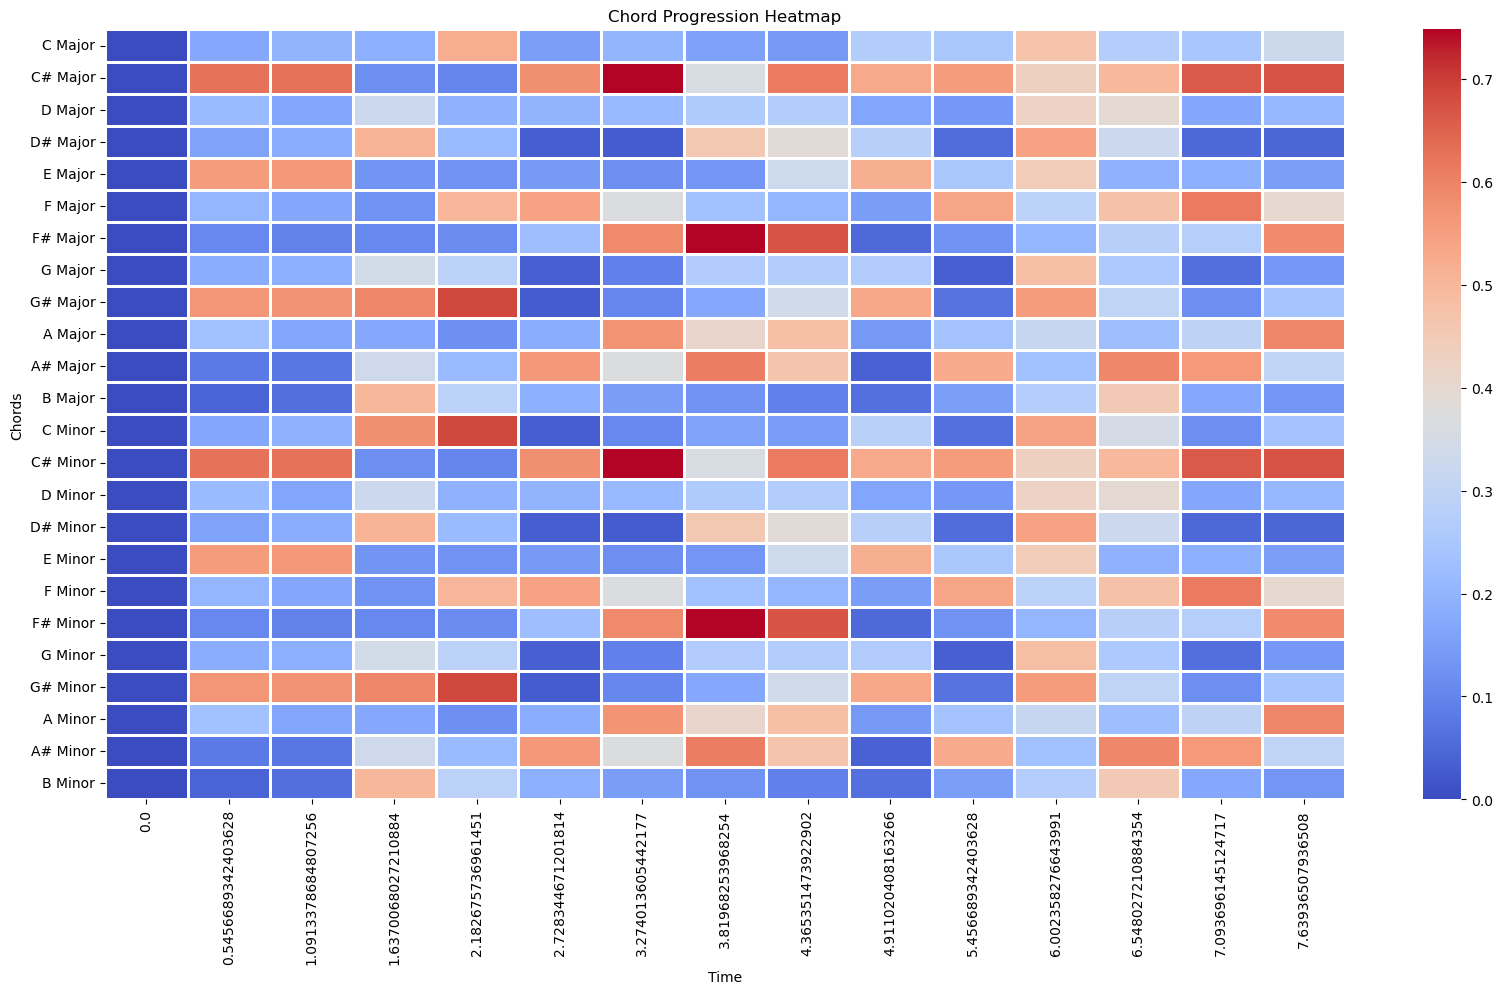

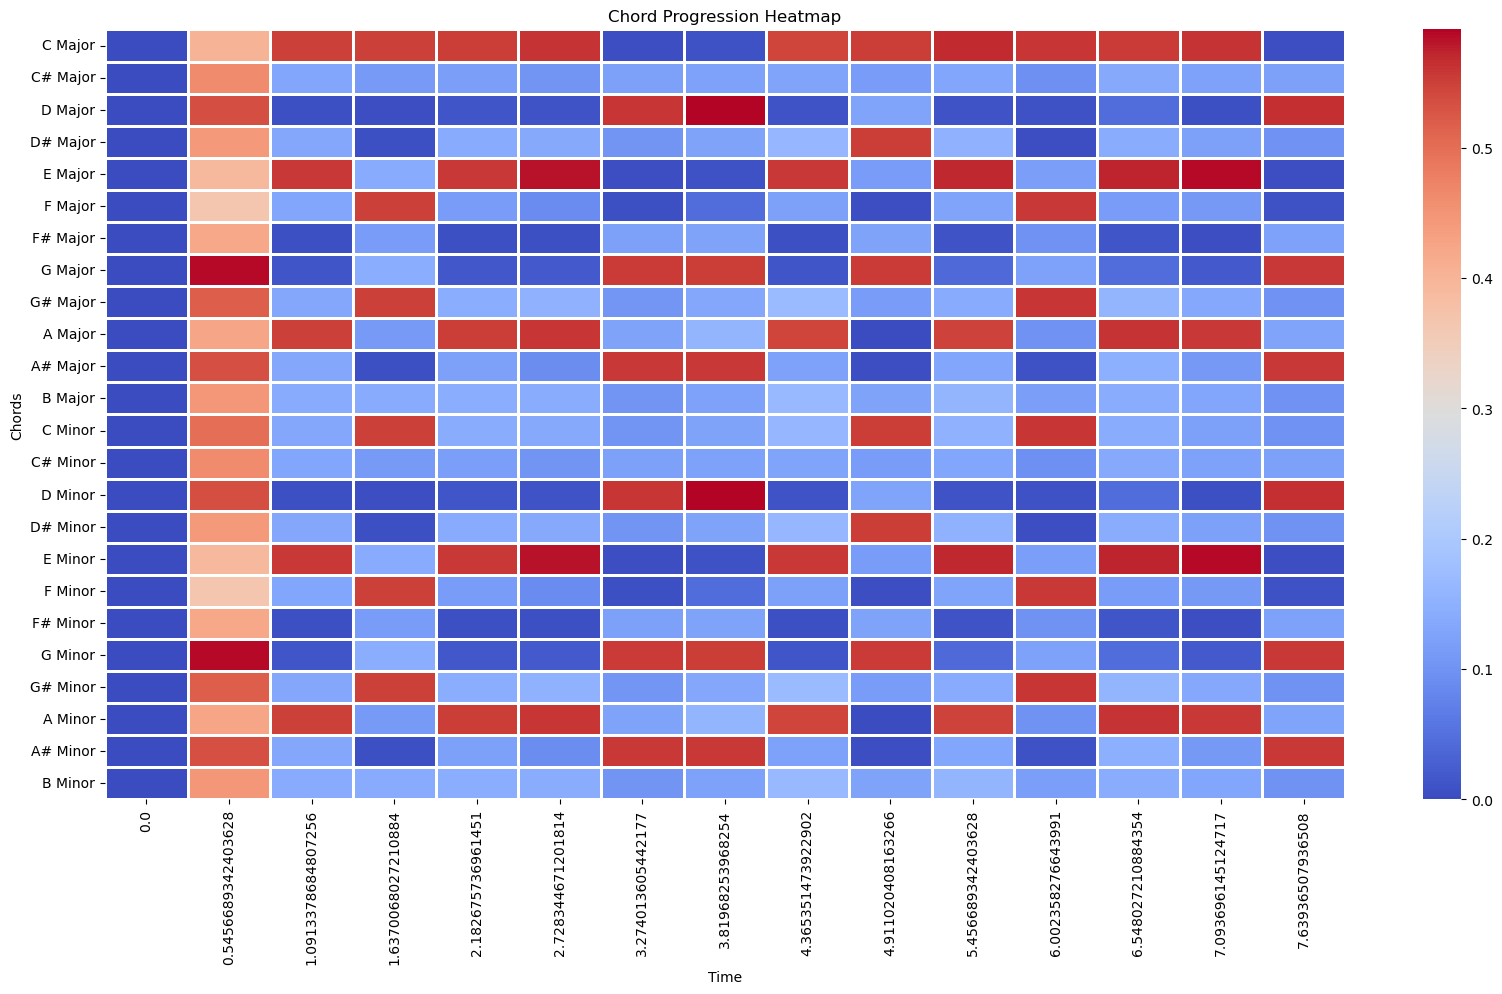

In [6]:
plot_chord_heatmap(clean_chord_score_from_filename(AUDIO_FILE), window=(0, 8))
plot_chord_heatmap(clean_chord_score_from_filename(AUDIO_FILE_1), window=(0, 8))